In [ ]:
import pandas as pd
import numpy as np
import pickle as pickle
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Activation,Dropout
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Embedding
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from keras.mixed_precision.loss_scale_optimizer import optimizer
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import GridSearchCV
from tensorflow import keras
import matplotlib.pyplot as plt
import time

In [ ]:
# Read training data
train_data_preprocessing = pd.read_pickle(r'/content/drive/MyDrive/train_data_preprocessing.pkl')
train_data_preprocessing.head()

,D_43,S_27,D_46,S_3,S_7,D_62,D_48,D_61,P_3,D_78,...,D_64_O,D_64_R,D_64_U,D_68_0.0,D_68_1.0,D_68_2.0,D_68_3.0,D_68_4.0,D_68_5.0,D_68_6.0
0,0.015299,0.125000,0.525315,0.122883,0.142912,0.008623,0.029541,0.006843,0.571499,0.000157,...,1,0,0,0,0,0,0,0,0,1
1,0.015299,0.151876,0.525163,0.123322,0.138300,0.008230,0.025951,0.005912,0.567541,0.000989,...,1,0,0,0,0,0,0,0,0,1
2,0.015299,0.157648,0.524603,0.122873,0.131795,0.008893,0.022172,0.004770,0.571994,0.000962,...,1,0,0,0,0,0,0,0,0,1
3,0.015299,0.156025,0.524262,0.121764,0.129668,0.008972,0.016176,0.004602,0.572860,0.000856,...,1,0,0,0,0,0,0,0,0,1
4,0.015299,0.149802,0.521516,0.121784,0.127735,0.008887,0.043572,0.003984,0.560242,0.000329,...,1,0,0,0,0,0,0,0,0,1


In [ ]:
test_data_preprocessing = pd.read_pickle(r'/content/drive/MyDrive/test_data_preprocessing.pkl')
test_data_preprocessing.drop(['S_2'], axis=1, inplace=True)

In [ ]:
def pad_customer_data(customer_data):
    # Check the number of rows for the customer
    num_rows = customer_data.shape[0]
    if num_rows < 13:
        # Calculate the number of rows to add
        num_rows_to_add = 13 - num_rows
        # Create an array of zeros for the new rows
        new_rows = np.zeros((num_rows_to_add, customer_data.shape[1]))
        # Concatenate the new rows to the customer data
        customer_data = np.concatenate([customer_data, new_rows], axis=0)
    return customer_data

In [ ]:
def paddle(df):
    df['rank'] = df.groupby('customer_ID')['date_diff'].rank(ascending=False)
    df.drop(['rank','date_diff','target'],inplace = True,axis = 1)
    # Create a list to store the padded sequences for each customer
    padded_sequences = []
    # Group the data by customer_id
    grouped_data = df.groupby('customer_ID')
    # Loop through each group
    for customer_id, group in grouped_data:
        group = group.drop('customer_ID', axis=1)
        # Convert the group to a numpy array
        customer_data = group.values
        # Pad the customer data and append to the list
        padded_sequences.append(pad_customer_data(customer_data))
    # Convert the list to a numpy array
    padded_sequences = np.array(padded_sequences)
    return padded_sequences

In [ ]:
y_train = train_data_preprocessing.groupby('customer_ID')['target'].max()
y_test = test_data_preprocessing.groupby('customer_ID')['target'].max()
train_array = paddle(train_data_preprocessing)
test_array = paddle(test_data_preprocessing)

In [ ]:
y_train.value_counts()

0.0    269390
1.0     93435
Name: target, dtype: int64

In [ ]:
# Compute class weights based on the frequency of each class in the training set
class_weights = compute_class_weight('balanced', classes = np.unique(y_train), y = y_train)
class_weights = dict(enumerate(class_weights))


In [ ]:
start_time = time.time()
metrics = [
    tf.keras.metrics.Recall(),
    tf.keras.metrics.AUC()
    ]
model = Sequential()
model.add(LSTM((100),batch_input_shape=(None,13,190)))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=metrics)
print(model.summary())
history = model.fit(train_array, y_train, epochs=10, batch_size=800, class_weight=class_weights)
print("--- %s seconds ---" % (time.time() - start_time))

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 100)               116400    
                                                                 
 dropout (Dropout)           (None, 100)               0         
                                                                 
 dense (Dense)               (None, 1)                 101       
                                                                 
Total params: 116,501
Trainable params: 116,501
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/10
454/454 [==============================] - 23s 43ms/step - loss: 0.2990 - recall: 0.9047 - auc: 0.9431
Epoch 2/10
454/454 [==============================] - 19s 41ms/step - loss: 0.2704 - recall: 0.9149 - auc: 0.9536
Epoch 3/10
454/454 [==============================] - 19s 41ms/step - loss: 0.265

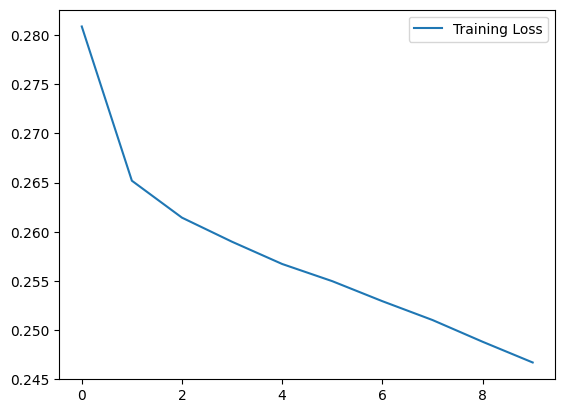

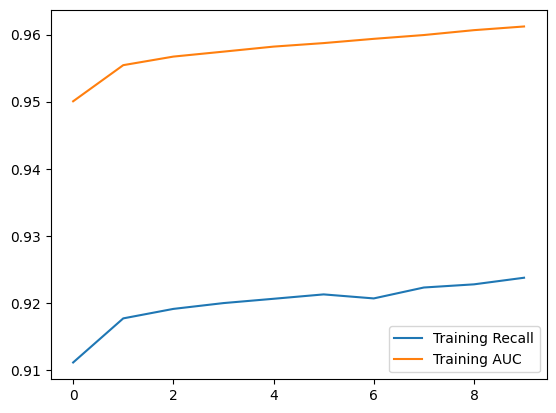

In [ ]:
# Plot the training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.legend()
plt.show()

# Plot the training and validation metrics
plt.plot(history.history['recall'], label='Training Recall')
plt.plot(history.history['auc'], label='Training AUC')
plt.legend()
plt.show()

In [ ]:
# Final evaluation of the model
scores = model.evaluate(test_array, y_test, verbose=0)
print(scores[0])
print(scores[1])
print(scores[2])

0.2712981104850769
0.9271196722984314
0.9580916166305542


In [ ]:
scores = model.evaluate(train_array, y_train, verbose=0)
print(scores[1])

0.958041787147522


In [ ]:
test_array.shape

(90706, 13, 191)

In [ ]:
train_data_preprocessing.shape

(4237534, 191)

In [ ]:
test_data_preprocessing.shape

(1057941, 192)

In [ ]:
y_pred = model.predict(test_array)

2835/2835 [==============================] - 13s 4ms/step


<Axes: >

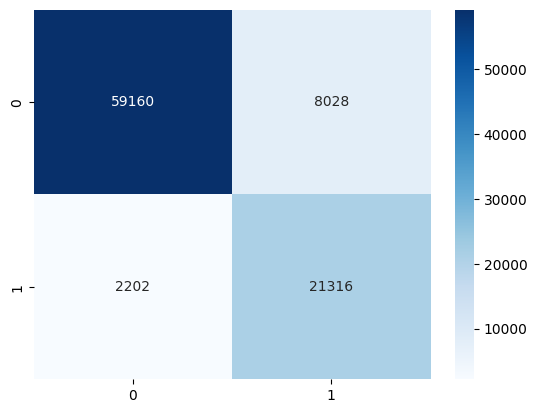

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
res_pred = np.where(y_pred < 0.5, 0, 1)
sns.heatmap(confusion_matrix(y_test,res_pred),annot=True,fmt='d', cmap='Blues')